In [1]:
# imported dependencies
import pennylane as qml
from itertools import product
import numpy as np
from collections import defaultdict

In [20]:
# Lets generate an arbitrary density matrix 
def generate_density_matrix():
    c1 = 1/np.sqrt(2)
    c2 = 1/np.sqrt(2)
    state = np.array([c1, 0, 0, 0, 0, 0, 0, c2])
    rho = np.outer(state, np.conj(state).T)
    return rho

<br>

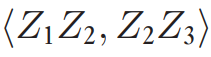

In [21]:
# We will use these generators for the rest of the demo!
def create_generators():
    # Create a generator set to detect bit flip errors 
    G1 = qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2)
    G2 = qml.PauliZ(0) @ qml.PauliZ(1) @ qml.Identity(2)

    G1 = G1.matrix()
    G2 = G2.matrix()
    return [G1, G2]

<br> 


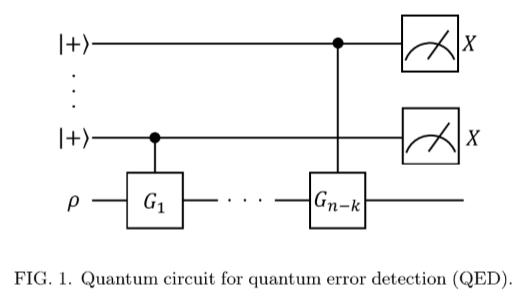

In [72]:
dev = qml.device("default.mixed", wires=5, shots=1)
@qml.qnode(dev)
def syndrome_measurement(density_matrix, generators, estimation_wires, target_wires):
    
    # Prepare target wires as our density matrix 
    qml.QubitDensityMatrix(density_matrix, wires=target_wires)
    
    for wire in estimation_wires:
        qml.Hadamard(wires=wire)
    
    # Introduce Bit Error
    qml.BitFlip(1, target_wires[2])

    L = len(estimation_wires)
    for i, generator in enumerate(generators):
        qml.ControlledQubitUnitary(generator, control_wires=estimation_wires[L-1-i], wires=target_wires)
    
    measurements = []
    for wire in estimation_wires:
        measurements.append(qml.sample(qml.PauliX(wire)))
    return measurements

<br>


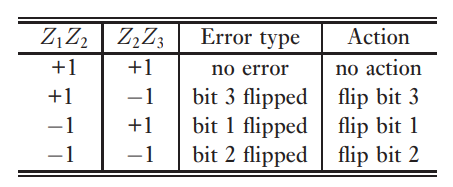

In [73]:
# Here rho is the ideal starting state with no noise applied
estimation_wires = [0,1]
target_wires = [2,3,4]
rho = generate_density_matrix()
print("Syndrome measurements:")
print(syndrome_measurement(rho, create_generators(), estimation_wires, target_wires))
print(qml.draw(syndrome_measurement)(rho, create_generators(), estimation_wires, target_wires))

Syndrome measurements:
[[ 1]
 [-1]]
0: ──H────────────────────────────────────────────╭●─────┤  Sample[X]
1: ──H─────────────────────────────────────╭●─────│──────┤  Sample[X]
2: ─╭QubitDensityMatrix(M0)────────────────├U(M1)─├U(M2)─┤           
3: ─├QubitDensityMatrix(M0)────────────────├U(M1)─├U(M2)─┤           
4: ─╰QubitDensityMatrix(M0)──BitFlip(1.00)─╰U(M1)─╰U(M2)─┤           
